In [9]:
import pandas as pd
import cobra
from matplotlib import pyplot as plt
from multime.auxotroph_analysis.load_model import load_me_model
import math
%matplotlib inline

In [10]:
import pandas as pd
df = pd.read_csv('../auxotroph_analysis/substrates/fluxes.csv', index_col=0)
df = df.dropna(axis=1)

df2 = pd.read_csv('../auxotroph_analysis/substrates_anaerobic/fluxes.csv', index_col=0)
df2 = df2.dropna(axis=1)

flux_df = df.join(df2)

In [41]:
currency_to_syn = {'coa': 'DPCOAK',
                                 'thf': 'DHFS',
                                 # use this reaction because DHFR is coupled to dUMP synthesis
                                 'nadp': 'NADK',
                                 'nad': 'NADS1',
                                 # need two reactions, one creates intermedaite for NADK, other couples
                                 'ribflv': 'RBFSb',
                                 'gthrd': 'GTHS',
                                 'q8h2': 'DMQMT',
                                 '2dmmql8': 'DHNAOT4',
                                 # must make 2dmmql8 to produce mql8
                                 'mql8': 'AMMQLT8'
                                 }
ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/Desktop/ecoli_M_models/iJO1366.json')
df = pd.read_csv('/home/sbrg-cjlloyd/Desktop/log_tpm.txt', index_col=0)
metadata = pd.read_csv('/home/sbrg-cjlloyd/Desktop/metadata.csv', index_col=0)

In [42]:
unevolved = True
if unevolved:
    # TODO ASK ANAND about the MISC project
    metadata = metadata.loc[[i for i in metadata.index if 'del' not in i]] # remove deletions
    metadata = metadata[~metadata.project_id.isin(['pal', 'fps', 'efeU', 'rpoB', 'oxidative', 'acid', 'fur',
                                                  '42c', 'pgi', 'misc'])] # these contain knockouts, acidic conditions, etc.
    # only wild-type of ssw
    metadata = metadata[(metadata.project_id != 'ssw') | (metadata.condition_id.str.contains('wt'))]

    # get rid of acidic
    metadata = metadata[~(metadata.condition_id.str.contains('_ph'))]

    # get rid of evolutions, throws off comparisons when rest of samples are unevolved
    metadata = metadata[~(metadata.condition_id.str.contains('ale'))]


    # Only consider aerobic or anaerobic
    metadata = metadata[metadata['Electron Acceptor'] != 'KNO3(20mM)']
else:
    metadata = metadata[metadata['Evolved Sample'] != 'No']
    metadata = metadata.loc[[i for i in metadata.index if 'del' not in i]] # remove deletions
    metadata = metadata[~metadata.project_id.isin(['pal', 'fps', '42c', 'rpoB', 'oxidative', 'acid', 'fur',
                                                  'pgi', 'efeU'])]
    
    # get rid of switching evolutions
    metadata = metadata[(metadata.condition_id.str.contains('ale'))]

In [43]:
metadata = metadata[['study', 'project_id', 'condition_id', 'Strain', 'Base Media', 
          'Carbon Source (g/L)', 'Nitrogen Source (g/L)', 'Electron Acceptor', 'Supplement', 'Trace Element Mixture',
         'Evolved Sample']]

In [51]:
source_df = metadata[metadata.Supplement.isnull()]
supplement_df = metadata[~metadata.Supplement.isnull()]

In [52]:
media_to_met = {'acetate': 'ac_e', 'fructose': 'fru_e', 'glycerol': 'glyc_e', 'xylose': 'xyl__D_e',
               'glutamine': 'gln__L_e', 'cytosine': 'csn_e', 'cytidine': 'cytd_e'}
for i, row in source_df.iterrows():
    c_source = row['Carbon Source (g/L)'].split('(')[0]
    n_source = row['Nitrogen Source (g/L)'].split('(')[0]
    aerobicity = 'aerobic' if row['Electron Acceptor'] == 'O2' else 'anaerobic'
    
    intermediate = '' if aerobicity == 'aerobic' else 'anaerobic_'
    
    if c_source == 'glucose' and n_source == 'NH4Cl':
        cond = 'C_%sglc__D_e' % intermediate
    elif c_source != 'glucose':
        cond = 'C_' + media_to_met[c_source]
    elif n_source != 'NH4Cl':
        cond = 'N_' + media_to_met[n_source]
    else:
        cond = ''
    source_df.loc[i, 'ME_condition'] = cond

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipyk

In [53]:
out_df = pd.DataFrame()
for source, temp_df in source_df.groupby('ME_condition'):
    val_df = df[temp_df.index].applymap(lambda x: 10**x)
    #for gene in val_df.index:
    out_df[source] = val_df.T.mean()
    out_df['std_' + source] = val_df.T.std()
    #out_df.loc[source, ]

In [54]:
full = False
col_names = []
cluster_df = pd.read_csv('/home/sbrg-cjlloyd/Desktop/cofactor_expression.csv', index_col=0)
me = load_me_model()
for i in cluster_df.columns:
    try:
        met = me.metabolites.get_by_id(i + '_c')
    except:
        met = me.metabolites.get_by_id(i)
    if not met.name:
        met.name = met.id.replace("_c", '')
    elif met.id == 'nadp_c':
        met.name = 'nadp'
    elif met.id == 'nad_c':
        met.name = 'nad'
    elif met.id == 'fad_c':
        met.name = 'fad'
    if not full:
        met.name = met.id.replace("_c", "")
    col_names.append(met.name)
cluster_df.columns = col_names

binary_df = cluster_df[cluster_df == 0].dropna(axis=1, how='all').fillna(1)
binary_df[binary_df > 0] = 1

#cluster_df = cluster_df[cluster_df != 0].dropna(axis=1, how='any').applymap(math.log2)

12.0 protein_b3946 --> EG11905-MONOMER
10000.0
coa_p not in model
10000.0
thf_p not in model
10000.0
nadp_p not in model
10000.0
nad_p not in model
10000.0
ribflv_p not in model
10000.0
10000.0
q8_p not in model
10000.0
2dmmq8_p not in model
10000.0
mqn8_p not in model
10000.0
fmn_p not in model
10000.0
fad_p not in model


In [55]:
out_df

,C_ac_e,std_C_ac_e,C_anaerobic_glc__D_e,std_C_anaerobic_glc__D_e,C_fru_e,std_C_fru_e,C_glc__D_e,std_C_glc__D_e,C_glyc_e,std_C_glyc_e,C_xyl__D_e,std_C_xyl__D_e,N_csn_e,std_N_csn_e,N_cytd_e,std_N_cytd_e,N_gln__L_e,std_N_gln__L_e
b0002,2.477191e+09,2.142195e+09,8.298231e+10,4.740531e+10,1.222909e+11,7.969222e+10,1.148536e+11,9.106306e+10,1.685884e+10,1.465411e+10,1.306703e+12,NaN,1.499880e+11,8.712252e+09,1.109519e+10,1.632462e+08,1.796067e+10,1.865113e+09
b0003,4.613789e+08,3.904463e+08,2.978730e+10,1.315458e+10,1.457975e+10,2.583283e+09,2.481124e+10,1.567050e+10,5.522949e+09,4.579249e+09,7.654294e+11,NaN,3.175524e+10,4.210762e+09,3.670588e+09,6.129362e+08,5.135307e+09,7.212457e+08
b0004,3.271086e+08,2.633569e+08,2.179203e+10,5.370407e+09,1.497415e+10,7.017261e+09,4.464100e+10,3.720588e+10,9.184524e+09,7.481085e+09,9.834893e+11,NaN,2.126162e+10,3.545370e+09,3.803616e+09,5.547235e+08,4.522284e+09,8.632534e+08
b0005,2.827418e+04,2.380322e+04,1.287669e+06,9.359475e+05,9.965084e+05,4.167596e+05,9.624476e+05,6.702679e+05,3.799242e+05,3.999588e+05,1.755924e+07,NaN,1.698488e+05,1.098001e+05,4.290210e+04,3.589053e+02,6.732124e+04,1.801515e+04
b0006,2.565912e+06,1.194854e+06,1.809862e+06,2.196979e+05,3.980646e+06,9.964117e+05,7.355643e+06,2.153948e+06,2.493266e+06,9.116318e+05,1.931645e+05,NaN,9.511309e+06,1.752033e+06,7.284641e+06,2.595094e+06,7.902769e+06,8.248603e+05
b0007,1.105626e+04,8.093211e+02,1.722678e+05,1.881204e+05,1.096757e+04,9.880497e+03,5.926951e+03,6.265711e+03,9.106540e+04,1.548899e+05,5.817540e+04,NaN,1.457905e+04,8.431565e+03,4.446876e+03,2.541864e+03,1.951850e+04,1.267814e+04
b0008,2.805596e+10,1.146770e+10,2.120768e+10,5.402266e+09,8.299644e+10,2.075790e+10,1.168733e+11,6.952853e+10,7.198330e+10,3.582867e+10,6.446120e+10,NaN,3.087071e+10,4.616706e+07,3.818362e+10,1.411075e+09,4.176801e+10,1.564090e+09
b0009,1.216576e+06,2.867541e+05,8.189689e+05,1.415299e+05,1.566253e+06,1.566242e+06,1.163806e+06,6.038834e+05,7.963634e+06,6.907606e+06,2.333363e+06,NaN,1.047720e+06,9.917219e+04,7.318169e+05,3.255504e+05,6.704180e+05,7.448430e+04
b0010,2.631196e+05,2.749860e+05,2.003538e+06,6.435420e+05,1.572297e+05,1.161183e+05,4.031576e+05,4.014317e+05,1.076184e+06,1.654987e+06,7.094843e+05,NaN,4.888055e+05,1.062669e+05,6.693369e+04,1.359836e+04,1.642155e+05,4.773072e+04
b0011,8.150508e+02,9.063397e+02,4.549291e+03,5.322973e+03,3.701906e+02,2.837684e+02,3.267381e+02,4.448490e+02,2.754636e+03,4.356578e+03,2.548611e+03,NaN,1.371738e+03,1.169112e+02,9.359326e+01,8.909194e+01,4.906939e+02,2.632831e+02


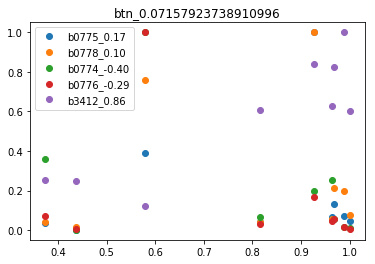

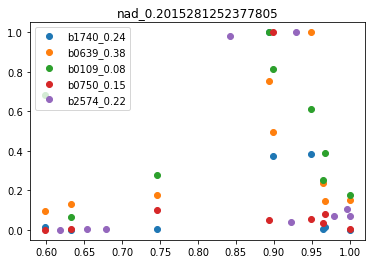

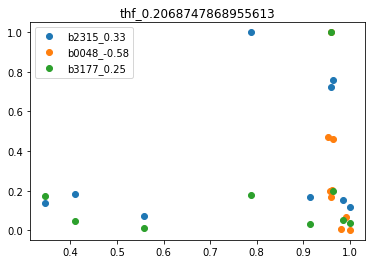

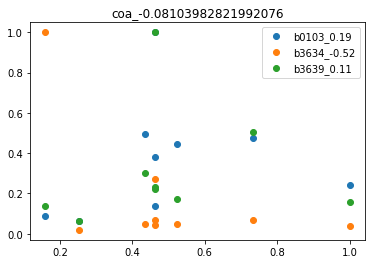

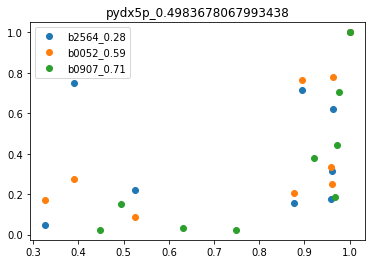

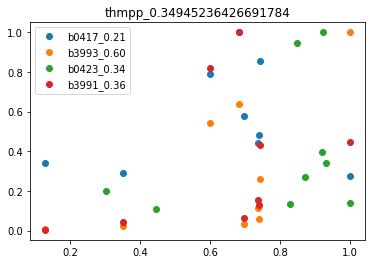

In [56]:
import numpy as np

#'nadp': 'nadK', 
gene_to_met = {'btn': ['b0775', 'b0778', 'b0774', 'b0776', 'b3412'], 
               'nad': ['b1740', 'b0639', 'b0109', 'b0750', 'b2574'],
               'thf': ['b2315', 'b0048', 'b3177'], #, 'b1606'
               'coa': ['b0103', 'b3634', 'b3639'], 
               'pydx5p': [ 'b2564', 'b0052', 'b0907'], #, 'b2418''b1638',
              'thmpp': ['b0417', 'b3993', 'b0423', 'b3991']}
for met, genes in gene_to_met.items():
    x_values = []
    y_values = []

    trans_dict = {}
    points = [i for i in out_df.columns if not i.startswith('std')]
    for point in points:
        sol = cobra.core.Solution(1, x_dict=flux_df[point], status='optimal')
        trans_dict[point] = me.get_translation_flux(solution=sol)
    trans_df = pd.DataFrame(trans_dict)
    trans_df = trans_df / trans_df.sum()
    for gene in genes:
        
        
        if source.startswith('std'):
            continue
        
        x = trans_df.loc[gene][points]
        x = x / x.max()
        
        y = (out_df[points] / out_df[points].sum()).T[gene]
        #yerr = out_df.loc[gene][['std_' + i for i in points]]
        #yerr= yerr / y.max()
        y = y / y.max()
        
        
        
        plt.errorbar(x, y,
                     label=gene + '_%.2f'% np.corrcoef(list(y), list(x))[1][0], fmt='o')
        x_values.extend(list(x))
        y_values.extend(list(y))
    plt.title(met + '_' + str(np.corrcoef(list(y_values), list(x_values))[1][0]))

    #plt.xlim([0, 1.2])
    #plt.ylim([0, 1.2])
    #plt.plot([0,1], [0,1], 'k')
    plt.legend()
    plt.show()

In [67]:
y

C_glc__D_e    0.940384
C_glyc_e      1.000000
C_xyl__D_e    0.031705
Name: b3991, dtype: float64

In [40]:
out_df

,C_ac_e,std_C_ac_e,C_anaerobic_glc__D_e,std_C_anaerobic_glc__D_e,C_fru_e,std_C_fru_e,C_glc__D_e,std_C_glc__D_e,C_glyc_e,std_C_glyc_e,C_xyl__D_e,std_C_xyl__D_e,N_csn_e,std_N_csn_e,N_cytd_e,std_N_cytd_e,N_gln__L_e,std_N_gln__L_e
b0002,2.477191e+09,2.142195e+09,8.298231e+10,4.740531e+10,1.222909e+11,7.969222e+10,1.148536e+11,9.106306e+10,1.685884e+10,1.465411e+10,1.306703e+12,NaN,1.499880e+11,8.712252e+09,1.109519e+10,1.632462e+08,1.796067e+10,1.865113e+09
b0003,4.613789e+08,3.904463e+08,2.978730e+10,1.315458e+10,1.457975e+10,2.583283e+09,2.481124e+10,1.567050e+10,5.522949e+09,4.579249e+09,7.654294e+11,NaN,3.175524e+10,4.210762e+09,3.670588e+09,6.129362e+08,5.135307e+09,7.212457e+08
b0004,3.271086e+08,2.633569e+08,2.179203e+10,5.370407e+09,1.497415e+10,7.017261e+09,4.464100e+10,3.720588e+10,9.184524e+09,7.481085e+09,9.834893e+11,NaN,2.126162e+10,3.545370e+09,3.803616e+09,5.547235e+08,4.522284e+09,8.632534e+08
b0005,2.827418e+04,2.380322e+04,1.287669e+06,9.359475e+05,9.965084e+05,4.167596e+05,9.624476e+05,6.702679e+05,3.799242e+05,3.999588e+05,1.755924e+07,NaN,1.698488e+05,1.098001e+05,4.290210e+04,3.589053e+02,6.732124e+04,1.801515e+04
b0006,2.565912e+06,1.194854e+06,1.809862e+06,2.196979e+05,3.980646e+06,9.964117e+05,7.355643e+06,2.153948e+06,2.493266e+06,9.116318e+05,1.931645e+05,NaN,9.511309e+06,1.752033e+06,7.284641e+06,2.595094e+06,7.902769e+06,8.248603e+05
b0007,1.105626e+04,8.093211e+02,1.722678e+05,1.881204e+05,1.096757e+04,9.880497e+03,5.926951e+03,6.265711e+03,9.106540e+04,1.548899e+05,5.817540e+04,NaN,1.457905e+04,8.431565e+03,4.446876e+03,2.541864e+03,1.951850e+04,1.267814e+04
b0008,2.805596e+10,1.146770e+10,2.120768e+10,5.402266e+09,8.299644e+10,2.075790e+10,1.168733e+11,6.952853e+10,7.198330e+10,3.582867e+10,6.446120e+10,NaN,3.087071e+10,4.616706e+07,3.818362e+10,1.411075e+09,4.176801e+10,1.564090e+09
b0009,1.216576e+06,2.867541e+05,8.189689e+05,1.415299e+05,1.566253e+06,1.566242e+06,1.163806e+06,6.038834e+05,7.963634e+06,6.907606e+06,2.333363e+06,NaN,1.047720e+06,9.917219e+04,7.318169e+05,3.255504e+05,6.704180e+05,7.448430e+04
b0010,2.631196e+05,2.749860e+05,2.003538e+06,6.435420e+05,1.572297e+05,1.161183e+05,4.031576e+05,4.014317e+05,1.076184e+06,1.654987e+06,7.094843e+05,NaN,4.888055e+05,1.062669e+05,6.693369e+04,1.359836e+04,1.642155e+05,4.773072e+04
b0011,8.150508e+02,9.063397e+02,4.549291e+03,5.322973e+03,3.701906e+02,2.837684e+02,3.267381e+02,4.448490e+02,2.754636e+03,4.356578e+03,2.548611e+03,NaN,1.371738e+03,1.169112e+02,9.359326e+01,8.909194e+01,4.906939e+02,2.632831e+02


In [276]:
trans_df.loc['b1638']

C_ac_e                  0.0
C_anaerobic_glc__D_e    0.0
C_fru_e                 0.0
C_glc__D_e              0.0
C_glyc_e                0.0
C_xyl__D_e              0.0
N_csn_e                 0.0
N_cytd_e                0.0
N_gln__L_e              0.0
Name: b1638, dtype: float64

In [286]:
me.metabolites.protein_b1636.reactions

frozenset({<ComplexFormation formation_PDXY-MONOMER at 0x7fcd4a7b6320>,
           <TranslationReaction translation_b1636 at 0x7fcd49e0f278>})

In [250]:
flux_df = pd.read_csv('../auxotroph_analysis/substrates/fluxes.csv', index_col=0)
flux_df = flux_df.dropna(axis=1)

In [287]:
me.metabolites.pydx_c.reactions

frozenset({<MetabolicReaction PYDXPP_FWD_EG11239-MONOMER_mod_mg2 at 0x7fcd4f564208>,
           <MetabolicReaction PYDXK_FWD_PDXY-MONOMER at 0x7fcd4a46bb00>,
           <MetabolicReaction PYDXK_FWD_PDXK-CPLX at 0x7fcd80166940>,
           <MetabolicReaction PYDXPP_FWD_G6246-MONOMER_mod_mg2 at 0x7fcd4a46bc50>,
           <MetabolicReaction PYDXPP_FWD_EG11470-MONOMER_mod_mg2 at 0x7fcd4f5647b8>,
           <MetabolicReaction PYDXtpp_FWD_CPLX_dummy at 0x7fcd4f564cf8>})

In [283]:
for r in me.metabolites.pydx5p_c.reactions:
    if me.metabolites.pydx5p_c in r.products:
        print(r, r.reaction)

PYDXK_FWD_PDXK-CPLX 0.000111103088389418*mu PDXK-CPLX + atp_c + pydx_c --> adp_c + h_c + pydx5p_c
PYAM5PO_FWD_PDXH-CPLX_mod_fmn 0.000111105832190679*mu PDXH-CPLX_mod_fmn + h2o_c + o2_c + pyam5p_c --> h2o2_c + nh4_c + pydx5p_c
PDX5POi_FWD_PDXH-CPLX_mod_fmn 0.00925925925925926*mu PDXH-CPLX_mod_fmn + o2_c + pdx5p_c --> h2o2_c + pydx5p_c
PYDXK_FWD_PDXY-MONOMER 0.000111103088389418*mu PDXY-MONOMER + atp_c + pydx_c --> adp_c + h_c + pydx5p_c
PDX5PO2_FWD_CPLX_dummy 0.00011012193004145*mu CPLX_dummy + 0.001*mu + 1.0 nad_c + pdx5p_c --> h_c + nadh_c + pydx5p_c


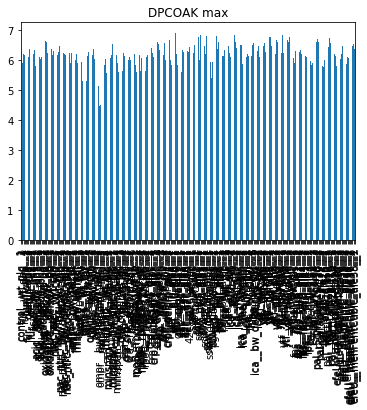

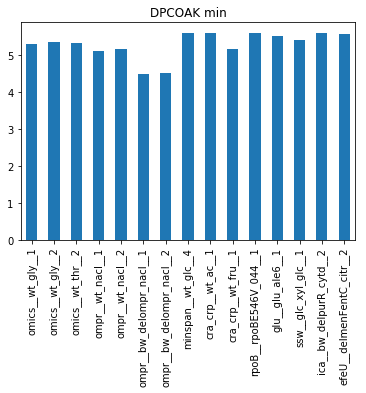

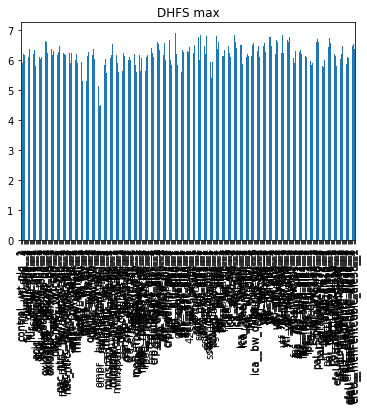

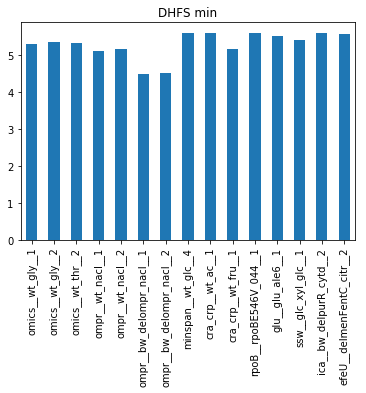

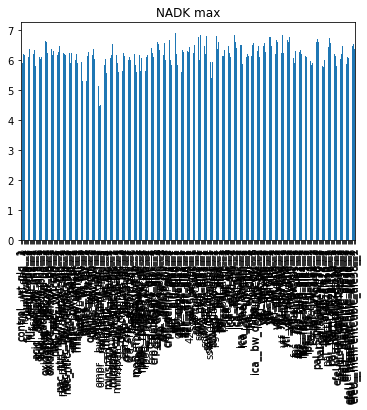

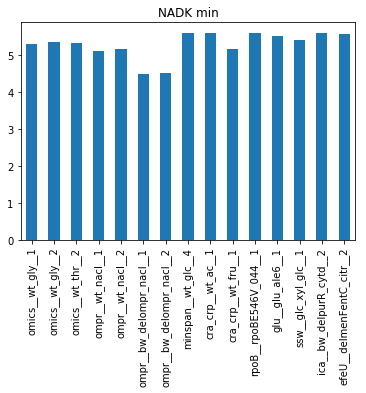

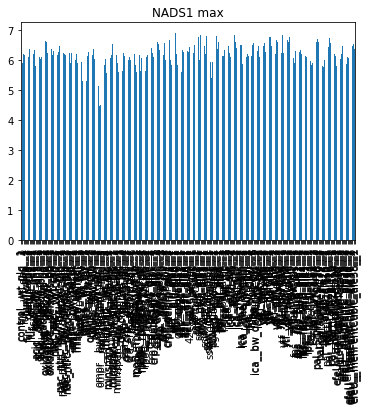

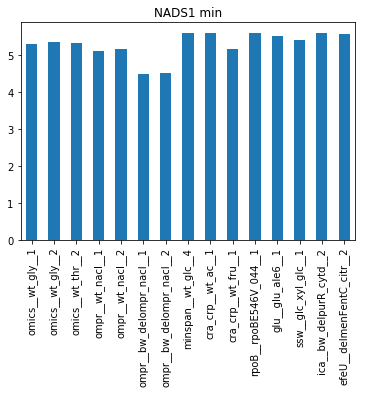

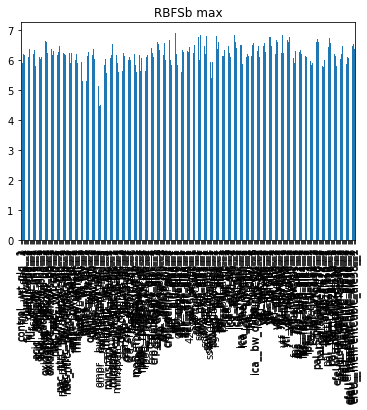

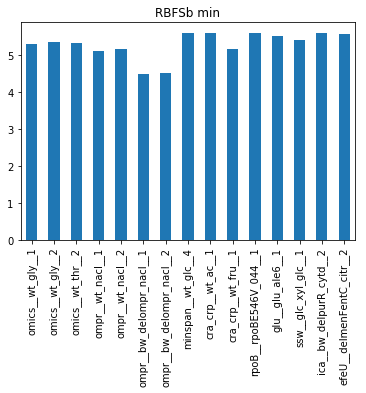

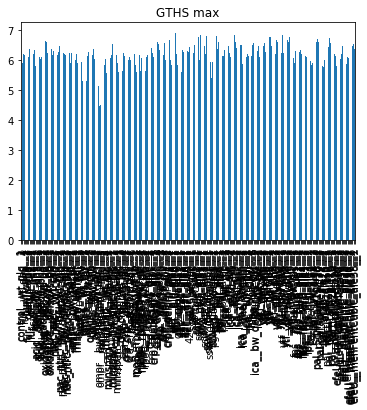

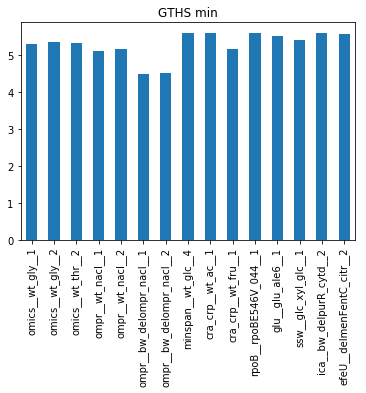

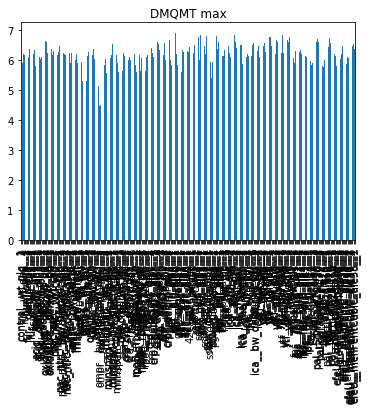

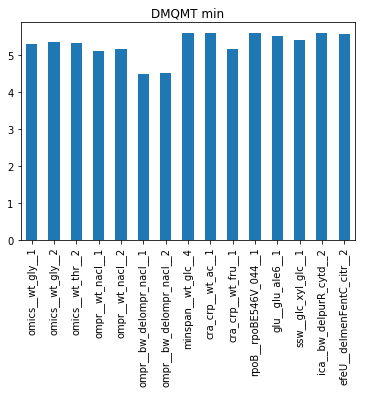

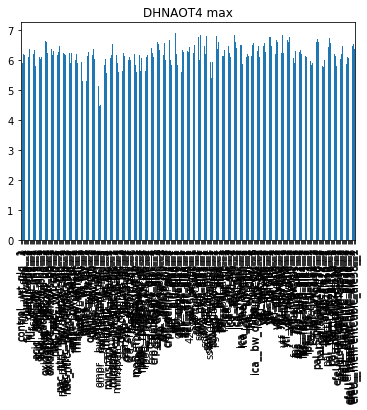

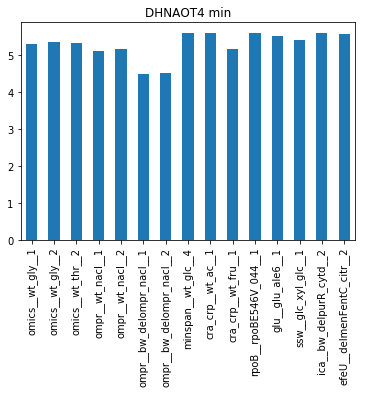

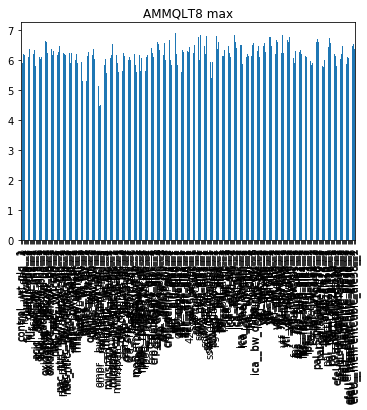

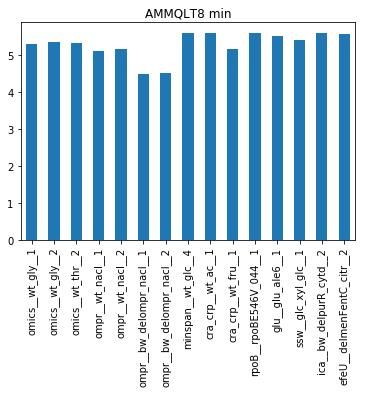

In [7]:
for k, r in currency_to_syn.items():
    for gene in ijo.reactions.get_by_id(r).genes:
        gene.id = 'b1270'
        fig, ax = plt.subplots(1,1)
        df.T[gene.id][df.T[gene.id] > df.T[gene.id].max()*0].plot(kind='bar', ax=ax)
        ax.set_title(r + ' max')
        fig, ax = plt.subplots(1,1)
        df.T[gene.id][df.T[gene.id] < df.T[gene.id].min()*1.25].plot(kind='bar', ax=ax)
        ax.set_title(r + ' min')

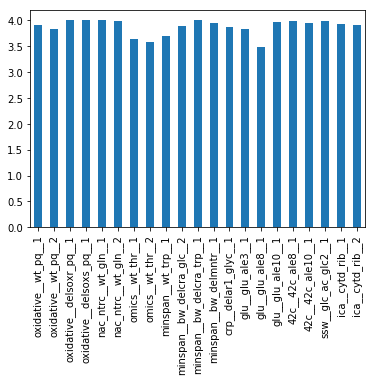

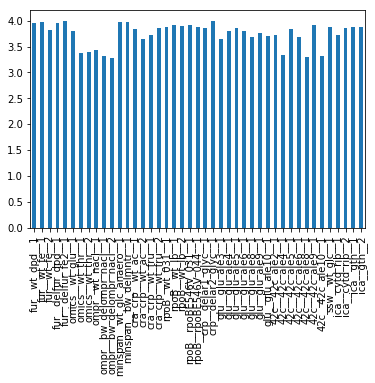

In [20]:
df.T['b3973'][df.T['b3973'] < 4].plot(kind='bar')

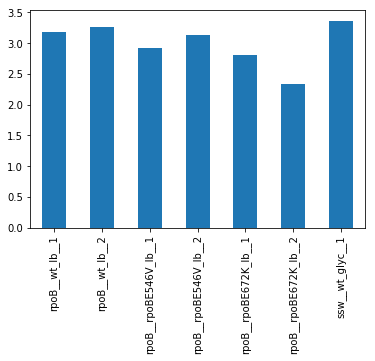

In [19]:
df.T['b0750'][df.T['b0750'] < 4].plot(kind='bar')

In [16]:
prot_df = pd.read_excel('/home/sbrg-cjlloyd/me_validation/me_validation_resources/proteomics_data/Aebersold_copy_numbers.xlsx')